Реализуйте один из оптимизаторов на выбор. Придумайте и напишите тесты для проверки выбранного оптимизатора. Проведите обучение нейрона из первого задания с использованием оптимизатора, а не ванильного градиентного спуска.
Также опишите идею алгоритма (+1 балл).
{*} Можете реализовать более 1 алгоритма. Каждый следующий даст 1 балл. \
Adam (5 баллов)

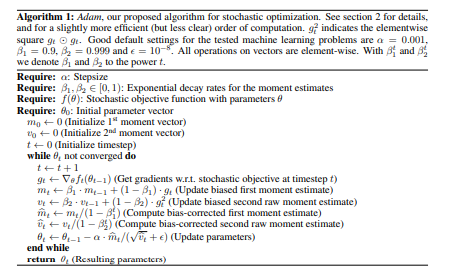 \
Материал из публикации https://arxiv.org/pdf/1412.6980.

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from support import Neuron

%matplotlib ipympl 

### Работа adam
Adam использует идеи momentum,adaptive learning rates предложенные в алгоритмах других оптимизаторов.\
Для этого адам вычисляет первый момент (среднюю производную), второй момент (квадратичную производную), которые контролируются гиперпараметрами $\beta_1, \beta_2$.\
Т.к алгоритм зависит от моментов времени t, возникает проблема инициализации нулями которая решается, корректировкой смещения, первого и второго момента на (1 - $\beta_{1,2}^t$).\
Сходимость тут -> https://arxiv.org/pdf/1412.6980. :)

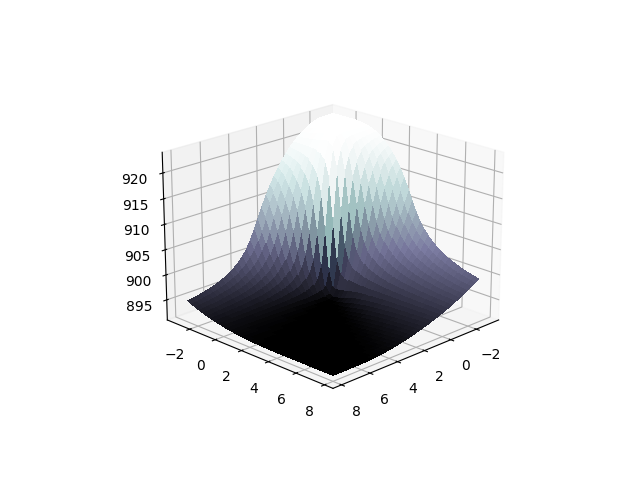

In [23]:
from matplotlib.colors import LightSource
from matplotlib import colormaps

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def f1(x1,x2):
    #surface
    return ((x1+ x2*3/2)**2)/3
    # return ((np.sin(x1) + x2*3/2 + np.random.normal(0,0.05))**2)/3


st1 = np.arange(-3,8,0.3)
st2 = np.arange(-3,8,0.3)

sx1 = np.arange(-4,8,0.5)
sx2 = np.arange(-4,8,0.5)
meshx = np.array(np.meshgrid(sx1,sx2)).T.reshape(-1,2)

mse_surf = []
for t1 in st1:
    m = []
    for t2 in st2:
        m.append(np.mean(np.apply_along_axis(lambda q: (f1(q[0],q[1]) - sigmoid(t1*q[0]+t2*q[1]))**2,1, meshx)))
    mse_surf.append(m)

mse_surf = np.array(mse_surf)
ls = LightSource(360, 40)
rgb = ls.shade(mse_surf, cmap=colormaps["bone"], vert_exag=0.01, blend_mode='soft')

mst1,mst2 = np.meshgrid(st2,st1)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.view_init(azim=45, elev=20)
surf = ax.plot_surface(mst1, mst2, mse_surf, rstride=1, cstride=1,linewidth=0,facecolors=rgb, antialiased=False, shade=False, )

In [24]:
# without bias for simpler visualization
n5 = Neuron([0,-2],0,0.1,1, with_bias=False)
ada_par = {"beta1":0.9, "beta2":0.9995}
n6 = Neuron([0,-2],0,0.1,1, grad="sgd", optimizer="adam",with_bias=False, **ada_par)

In [25]:
wei5 = []
wei6 = []

meshx
z = np.apply_along_axis(lambda q: f1(q[0],q[1]), 1, meshx)
print(meshx.shape, z.shape)

for i in range(100):
    n5.fit(meshx,z)
    n6.fit(meshx,z)
    wei5.append(n5.weights.copy())
    wei6.append(n6.weights.copy())

(576, 2) (576,)


best loss: classic 891.6179999999999 adam 891.6377


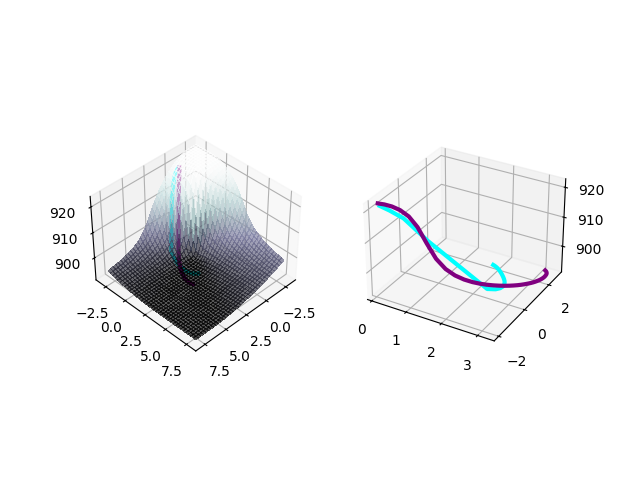

In [26]:
loss5 = np.array(n5.metadata["loss"])+0.01
loss6 = np.array(n6.metadata["loss"])+0.01
print("best loss:", f"classic {loss5[-1]}", f"adam {loss6[-1]}")

fig, ax = plt.subplots(ncols=2, subplot_kw=dict(projection='3d'))
ax[0].view_init(azim=45, elev=40)
dx1 = np.apply_along_axis(lambda q: q[0], 1, wei6)
surf = ax[0].plot_surface(mst1, mst2, mse_surf, rstride=1, cstride=1,linewidth=0,facecolors=rgb, antialiased=False, shade=False, alpha = 0.65)
line1 = ax[0].plot(np.apply_along_axis(lambda q: q[0], 1, wei5), np.apply_along_axis(lambda q: q[1], 1, wei5), loss5, color = "cyan", linewidth=3, label = "classic")
line2 = ax[0].plot(np.apply_along_axis(lambda q: q[0], 1, wei6), np.apply_along_axis(lambda q: q[1], 1, wei6), loss6, color = "purple",linewidth=3, label = "adam")

line1 = ax[1].plot(np.apply_along_axis(lambda q: q[0], 1, wei5), np.apply_along_axis(lambda q: q[1], 1, wei5), loss5, color = "cyan", linewidth=3, label = "classic")
line2 = ax[1].plot(np.apply_along_axis(lambda q: q[0], 1, wei6), np.apply_along_axis(lambda q: q[1], 1, wei6), loss6, color = "purple",linewidth=3, label = "adam")

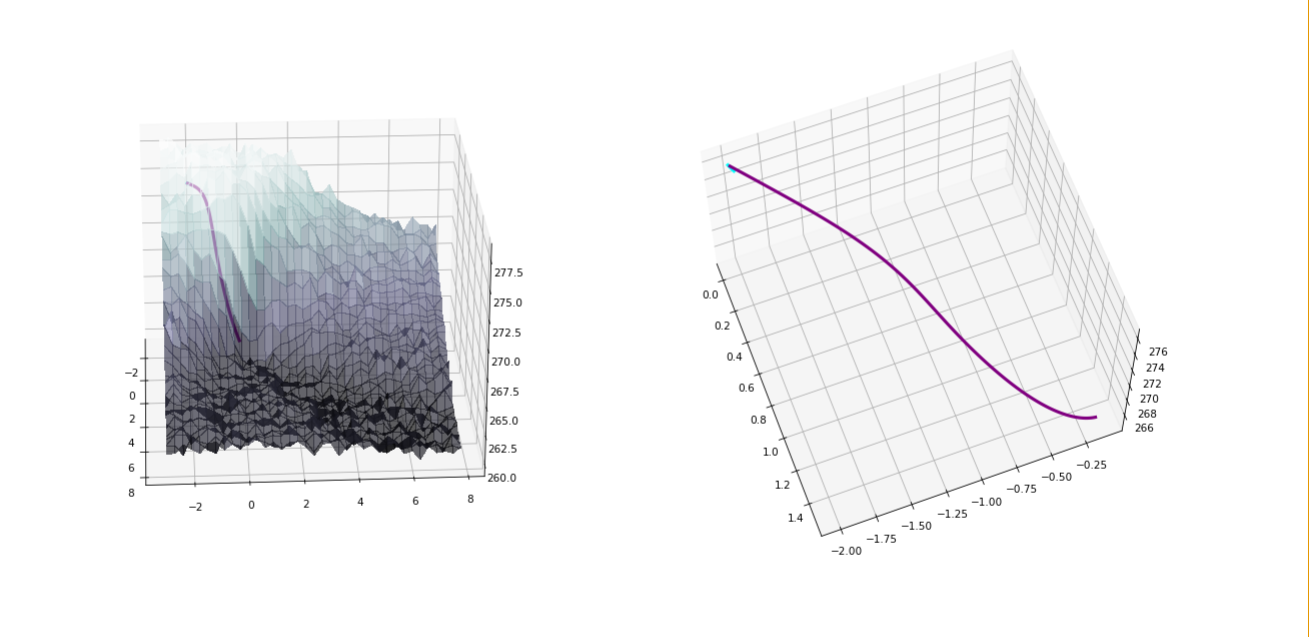 \
Для случая поверхности с множеством локальных минимумов ((np.sin(x1) + x2*3/2 + np.random.normal(0,0.05))**2)/3 видим, что классический градиент(голубой) застрял в локальном минимуме, когда adam, постепенно движется к абсолют. мин.

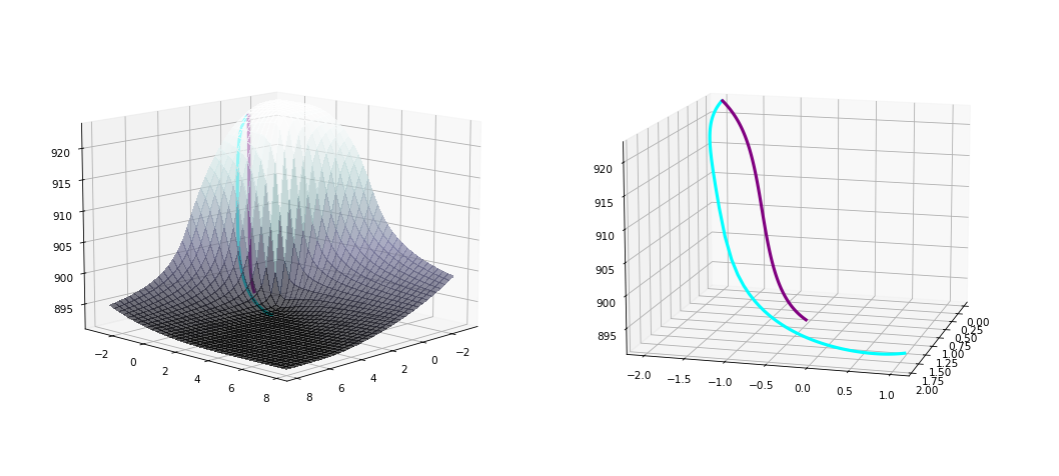\
В случае гладкой поверхности с одним минимумом ((x1+ x2*3/2)**2)/3 \
классический алгоритм(голубой) получает лучшие результаты за одинаковое количество шагов. Хотя траектория adam выглядит более правдоподобно, возможно следует увеличить скорость обучения, чтобы ускорить прохождение по этой траектории.

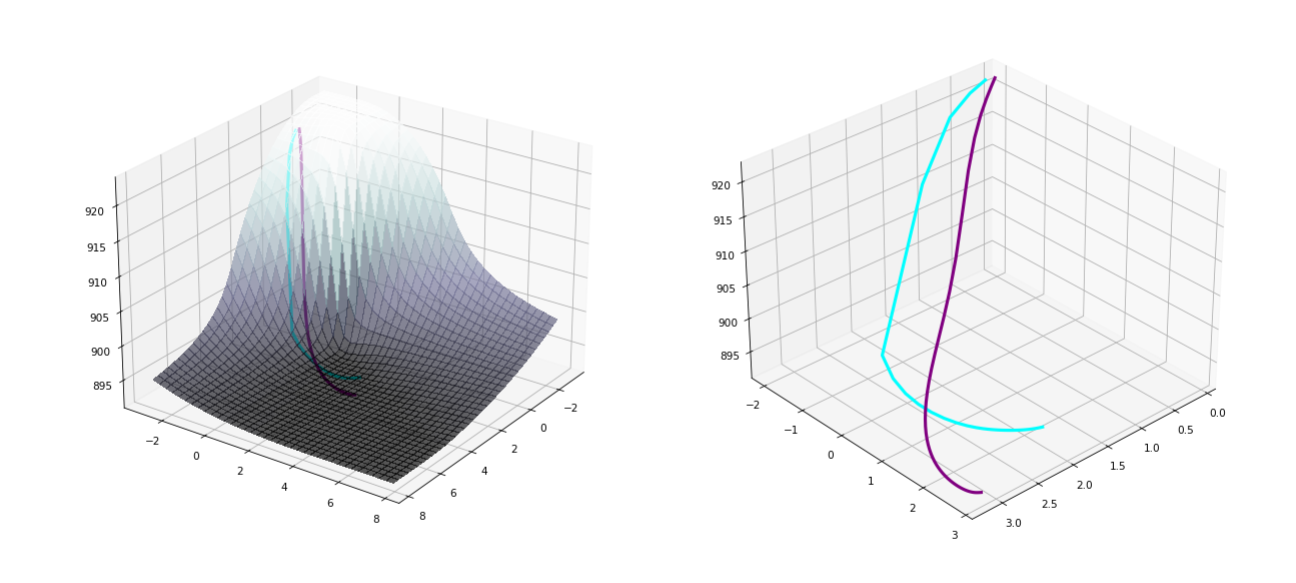\
Увеличил learning rate в 10 раз. Разница в лоссе 0.05. То есть практически удалось компенсировать прошлую особенность adam. При этом траектория классического алгоритма(голубой), выглядит избыточной.